# Calculate the energy convex hull of Al-Cu alloy structures.

This script depends on [genstr](https://www.brown.edu/Departments/Engineering/Labs/avdw/atat/manual/node54.html), a tool for generating the alloy structures in [ATAT](https://www.brown.edu/Departments/Engineering/Labs/avdw/atat/) package. This tool is licensed under [a Creative Commons Attribution-NoDerivatives 4.0 International License](https://www.brown.edu/Departments/Engineering/Labs/avdw/atat/manual/node2.html).

[ATAT User Guide](https://www.brown.edu/Departments/Engineering/Labs/avdw/atat/manual/manual.html)




1. Read initial lattice geometries in the directory "./input/"
2. Optimize the initial geometries.
3. Generate alloy structures for each geometries using "genstr".
4. Calculate the energy of alloy structures.
5. Plot the energies as functions of the fractions.

In [1]:
import os, sys ,glob, re
import numpy as np
import pandas as pd
from itertools import cycle
from subprocess import run, PIPE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from ase.io import read, write, Trajectory
from ase import Atoms, units
from ase.data import atomic_numbers

from ase.visualize import view
from ase.calculators.emt import EMT
from ase.optimize import BFGS
from ase.constraints import ExpCellFilter
from ase.build import bulk
from tqdm import tqdm


In [2]:
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

from pfcc_extras.structure.ase_rdkit_converter import smiles_to_atoms, atoms_to_smiles
from pfcc_extras.visualize.view import view_ngl
from matlantis_features.features.common.fire_lbfgs import FIRELBFGS

MODEL_VERSION='v3.0.0'
CALC_MODE='CRYSTAL'

/home/jovyan/.local/lib/python3.7/site-packages/pfp_api_client/__init__.py:36: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  f"New version of {package_name} is available. Please consider"


/home/jovyan/.local/lib/python3.7/site-packages/pfp_api_client/__init__.py:36: UserWarning: New version of matlantis-features is available. Please consider upgrading by `pip install -U matlantis-features`.
  f"New version of {package_name} is available. Please consider"
/home/jovyan/.local/lib/python3.7/site-packages/matlantis_features/features/common/fire_lbfgs.py:12: FutureWarning: matlantis_features.features.common.fire_lbfgs is deprecated; use ase_ext.optimize
  FutureWarning,


In [3]:

def read_atoms(filenames):
    atomses = [read(_) for _ in filenames]
    for atoms, filename in zip(atomses, filenames):
        atoms.info['filename'] = filename
    return atomses

def get_calculator(model_version=MODEL_VERSION, calc_mode=CALC_MODE):
    if isinstance(calc_mode, str):
        calc_mode = getattr(EstimatorCalcMode, CALC_MODE)
    estimator = Estimator(model_version=model_version, calc_mode=calc_mode)
    calculator = ASECalculator(estimator)
    return calculator, estimator

def opt_atomses(atomses, maxstep=0.2, fmax=0.01, steps=100):
    for atoms in atomses:
        calculator, estimator = get_calculator()
        atoms.set_calculator(calculator)
        atoms_ecf = ExpCellFilter(atoms, hydrostatic_strain=False)
        opt = BFGS(atoms_ecf, maxstep=maxstep)
        opt.run(fmax=fmax, steps=steps)
        print(atoms.get_total_energy())
    return atomses

In [4]:

def save_latin(atoms,
               replace_element={'Cu':'Cu,Al', 'Al':'Cu,Al'},
               interstitial_element=None, 
               dummy_element='H',
               filename='lat.in',
               verbose=False):
    
    cellpar = atoms.cell.cellpar()
    lat = '{:.4f} {:.4f} {:.4f} {:.1f} {:.1f} {:.1f}\n'.format(*cellpar)
    
    if verbose:
        print(f'Lattice parameters : {lat}')
        print('Lattice vectors:')
        for _c in atoms.cell:
            print(_c)

    for _ in np.eye(3):
        lat += '{} {} {}\n'.format(*_)

    for a in atoms:
        if a.number == atomic_numbers.get(interstitial_element):
            _elem = f'{interstitial_element},Vac'
        elif a.symbol in replace_element:
            _elem = replace_element[a.symbol]
        else:
            _elem = a.symbol
        lat += '{} {} {} {}\n'.format(*a.scaled_position, _elem)

    # Replace vacancy "Vac" with dummy element, mostly for visualization.
    if dummy_element is not None:
        lat = lat.replace('Vac', dummy_element) 

    if filename is not None:
        with open(filename, 'w') as f:
            f.write(lat)
    
    return lat

def str2atoms(strout):
    lines = strout.strip().splitlines()
    unitcell = np.array([_.split() for _ in lines[:3]], dtype=float)
    p = np.array([_.split() for _ in lines[3:6]], dtype=float)
    supercell = p @ unitcell

    tmp = [_.split() for _ in lines[6:]]
    pos = np.array([_[:3] for _ in tmp], dtype=float)
    symbols = np.array([_[3] for _ in tmp])
    if 'Vac' in symbols:
        mask = symbols != 'Vac'
        symbols = symbols[mask]
        pos = pos[mask]

    indexer = np.argsort(symbols)    
    pos = pos[indexer]
    symbols = symbols[indexer]
    atoms = Atoms(cell=supercell, symbols=symbols, positions=pos @ unitcell, pbc=1)
    atoms.wrap()
    return atoms


In [5]:


def save_latins(atomses,
               replace_element={'Cu':'Cu,Al', 'Al':'Cu,Al'},
                ):
    filenames = []
    latins = [] 
    for sampleId, atoms in enumerate(atomses):
        _geomfilename = atoms.info.get('filename')
        if _geomfilename is not None:
            dirname = os.path.dirname(_geomfilename)
        else:
            dirname = str(sampleId)
            os.makedirs(dirname, exist_ok=True)
        filename = os.path.join(dirname, 'lat.in')
        latin = save_latin(atoms, 
               replace_element=replace_element,
               filename=filename)
        filenames.append(filename)
        latins.append(latin)
    return filenames, latins

def gen_alloy_structures(filenames, sig=6, num_atoms=16, verbose=False):
    atomses_alloy = []
    
    for filename in tqdm(filenames):
        if verbose:
            print(filename)
        p = run(f'./genstr -l={filename} -sig={sig} -n={num_atoms}', shell=True, stdout=PIPE, stderr=PIPE, text=True)
    
        print(p.stderr) # エラーが無いことを確認します。
        structures = [_.strip() for _ in p.stdout.split('end') if _.strip()]
        atomses = [str2atoms(_.strip()) for _ in structures]

        atomses_alloy.append(atomses)
    return atomses_alloy

def clean_latins(filenames):
    for _ in filenames:
        os.remove(_)
        d = os.path.dirname(_)
        l = os.listdir(d)
        if len(l) == 0:
            os.rmdir(d)

In [6]:

def main(
    atomses = None,
    dirname = 'input',
    geomfiles = None,
    outputdir='output',
    sig = 6,
    num_atoms = 6,
    replace_element={'Cu':'Cu,Al', 'Al':'Cu,Al'},
    fmax=0.05,
    steps=20,
    maxstep=0.1,
    frac_max = 0.3,
    trajfiles = None,
    clean=True,
):
    
    # print(os.getcwd())
    if atomses is None:    
        if geomfiles is None and os.path.exists(dirname):
            geomfiles = sorted(glob.glob(os.path.join(dirname, '*', 'POSCAR')))

        print(f'{len(geomfiles)} geometries found.')
        print(geomfiles)
        atomses = read_atoms(geomfiles)
    
    print('\nThe usage of genstr.')
    p = run(f'./genstr', shell=True, stdout=PIPE, stderr=PIPE, text=True)
    print(p.stderr)
    
    print(f'Optimize the initial {len(atomses)} geometries.')
    
    atomses_initial = atomses
    atomses_initial = opt_atomses(atomses_initial)
    write(os.path.join(outputdir, f'relaxed_initial.traj'), atomses_initial)

    keys = k0, k1 = list(replace_element.keys())
    
    print(f'Generating alloy structures using genstr with replacing {k0} and {k1}.')
    latfiles, latins = save_latins(atomses_initial, replace_element=replace_element)
    atomses_alloy = gen_alloy_structures(latfiles, sig=sig, num_atoms=num_atoms)    
    #print(atomses_alloy)
    num_structures = np.array([len(_) for _ in atomses_alloy])
    for sampleid, atomses in enumerate(atomses_alloy):
        write(os.path.join(outputdir, f'initial_{sampleid:02d}.traj'), atomses)
    
    mask_no_structures = num_structures == 0
    print(f'{k0}-{k1} alloy structures are found :')
    print(f'    Number of structures for each lattice geometries : {num_structures}')
    print(f'    The largest cell size (number of atoms) of the alloy structures (below threshold < {num_atoms}): {[np.max([0]+[len(_) for _ in atomses]) for atomses in atomses_alloy]}')
    
    print(f'Calculating the energy of alloys...')
    if trajfiles is None:
        # basenames = [os.path.splitext(os.path.basename(geomfile))[0] for geomfile in geomfiles]
        # trajfiles = [f'relaxed_{sampleid:02d}_{basename}.traj' for sampleid, basename in enumerate(basenames)]
        trajfiles = [os.path.join(outputdir, f'relaxed_{sampleid:02d}.traj') for sampleid in range(len(atomses))]
    
    for sampleid, (atomses, trajfile) in enumerate(zip(atomses_alloy, trajfiles)):
        num_A = np.array([len(np.nonzero(_.numbers==atomic_numbers[k0])[0]) for _ in atomses])
        num_B = np.array([len(np.nonzero(_.numbers==atomic_numbers[k1])[0]) for _ in atomses])
        frac = num_B/(num_A + num_B)
        indexer = np.argsort(frac)
        # print(atomses)

        _atomses = np.empty(len(atomses), dtype=object)
        _atomses[:] = [atomses[i] for i in indexer]
        num_B = num_B[indexer]
        num_A = num_A[indexer]
        frac = frac[indexer]

        mask = frac < frac_max
        indexer = np.nonzero(mask)[0]
        print(f'Number of structures with occupation threshold < {frac_max}: {len(indexer)}/{len(mask)}')

        t = Trajectory(trajfile, 'a')
        for atoms in tqdm(_atomses[mask]):
            calculator, estimator = get_calculator()
            atoms.calc = calculator
            atoms.calc.reset()
            atoms_ecf = ExpCellFilter(atoms, hydrostatic_strain=False)
            logfile = os.path.join(outputdir, f'opt_{sampleid:02d}.log')
            opt = BFGS(atoms_ecf, logfile=logfile)
            opt.run(fmax=fmax, steps=steps)
            t.write(atoms)

        t.close()

    if clean:
        clean_latins(latfiles)

    return geomfiles, trajfiles, atomses_alloy

In [7]:
def plot(trajfiles, 
         geomfiles,
         replace_element={'Cu':'Cu,Al', 'Al':'Cu,Al'},
):

    # print(trajfiles)
    fig0, axes = plt.subplots(nrows=len(trajfiles), figsize=(8, 4*len(trajfiles)))
    fig1, ax1 = plt.subplots(figsize=(12,6))


    for ax, trajfile, color in zip (axes, trajfiles, cycle(mcolors.TABLEAU_COLORS)):
        # print(trajfile)
        if not os.path.exists(trajfile):
            continue
        trajs = read(trajfile, index=':')
        energies = np.array([_.get_total_energy()/len(_) for _ in trajs])
        if len(energies) == 0:
            continue

        keys = k0, k1 = list(replace_element.keys())
        num_A = np.array([len(np.nonzero(_.numbers==atomic_numbers[k0])[0]) for _ in trajs])
        num_B = np.array([len(np.nonzero(_.numbers==atomic_numbers[k1])[0]) for _ in trajs])
        frac = num_B/(num_A + num_B)
        
        indexer = np.argsort(frac)
        frac = frac[indexer]
        energies = energies[indexer]
        ax.scatter(frac, energies, color=color)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        x = xlim[0] + (xlim[1] - xlim[0]) * 0.1
        y = ylim[0] + (ylim[1] - ylim[0]) * 0.1

        ax.text(x, y, f'{trajfile}')
        ax1.scatter(frac, energies, color=color)
        ax1.set_xlabel(f'{k0}/({k0} + {k1})')
        ax1.set_ylabel('Energy, eV')

        x = []
        y = []
        frac_uniq, index, inverse, counts = np.unique(frac, True, True, True)
        energies_min = [np.min(energies[inverse==i]) for i in range(len(frac_uniq))]

        for i, (f,e) in enumerate(zip(frac_uniq, energies_min)):
            if i == 0 or i == len(frac_uniq)-1:
                x.append(f)
                y.append(e)
                continue
            if e < energies_min[i-1] + (energies_min[i+1]-energies_min[i-1]) * (f - frac_uniq[i-1])/(frac_uniq[i+1]-frac_uniq[i-1]):
                x.append(f)
                y.append(e)
        plt.plot(x,y, color=color, linestyle="dashed")


In [8]:
inputdir = 'input'
outputdir = 'output'
replace_element={'Cu':'Cu,Al', 'Al':'Cu,Al'}
    
os.makedirs(outputdir, exist_ok=True)

if os.path.exists(inputdir):
    atomses = None
    geomfiles = sorted(glob.glob(os.path.join(inputdir, '*', 'POSCAR')))
    _basenames = [_.split('/')[1] for _ in geomfiles]
    trajfiles = [os.path.join(outputdir, f'relaxed_{sampleid:02d}_{basename}.traj') for sampleid, basename in enumerate(_basenames)]
else:
    d = 2.55
    a_fcc = np.sqrt(2) * d
    a_bcc = 2.0/np.sqrt(3) * d
    
    atoms_fcc = bulk('Cu', 'fcc', a_fcc, cubic=False)
    atoms_bcc = bulk('Cu', 'bcc', a_bcc, cubic=False)
    atoms_hcp = bulk('Cu', 'hcp', d)
    atomses = [atoms_fcc, atoms_bcc, atoms_hcp]
    geomfiles = None
    trajfiles = [os.path.join(outputdir, f'relaxed_{_}.traj') for _ in ('fcc', 'bcc', 'hcp')]

res = main(atomses=atomses, geomfiles=geomfiles, trajfiles=trajfiles, outputdir=outputdir, replace_element=replace_element, num_atoms=6, frac_max=0.3)
geomfiles, trajfiles, atomses_alloy = res

del atomses_alloy



The usage of genstr.
GENerate STRuctures 3.36, by Axel van de Walle
  -n=[int]      maximum nb of atom/unit cell (Default: 0)
-sig=[int]      Number of significant digits to print in output files (Default: 6)
 -2d            Find supercells along a and b axes only (Default: Off)
  -l=[string]   Input file defining the lattice (default: lat.in)

Optimize the initial 3 geometries.
      Step     Time          Energy         fmax
BFGS:    0 07:36:45       -3.079002        0.2784
BFGS:    1 07:36:45       -3.081612        0.1596
BFGS:    2 07:36:45       -3.082925        0.0053
-3.082924947535844
      Step     Time          Energy         fmax
BFGS:    0 07:36:45       -3.045123        0.4056
BFGS:    1 07:36:46       -3.050962        0.2651
BFGS:    2 07:36:46       -3.055087        0.0177
BFGS:    3 07:36:46       -3.055106        0.0007
-3.0551056710806264
      Step     Time          Energy         fmax
BFGS:    0 07:36:46       -6.156102        0.6023
BFGS:    1 07:36:46       -6.16

 33%|███▎      | 1/3 [00:00<00:00,  9.80it/s]

100%|██████████| 3/3 [00:00<00:00,  8.97it/s]

Cu-Al alloy structures are found :
    Number of structures for each lattice geometries : [137 286  63]
    The largest cell size (number of atoms) of the alloy structures (below threshold < 6): [6, 6, 6]
Calculating the energy of alloys...
Number of structures with occupation threshold < 0.3: 23/137


100%|██████████| 23/23 [00:28<00:00,  1.25s/it]


Number of structures with occupation threshold < 0.3: 45/286


100%|██████████| 45/45 [01:28<00:00,  1.96s/it]


Number of structures with occupation threshold < 0.3: 9/63


100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


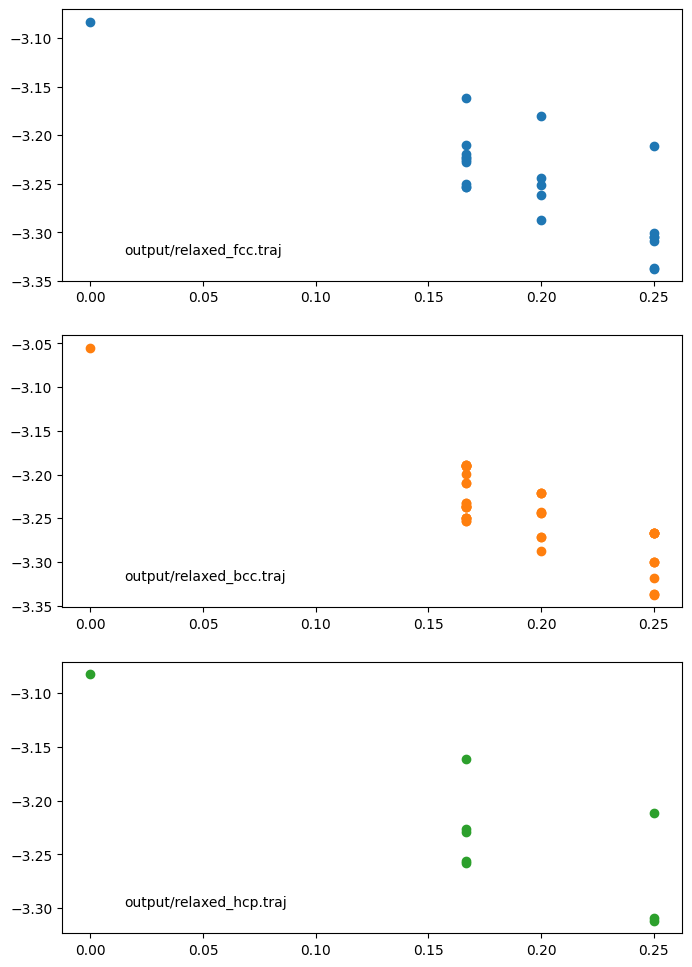

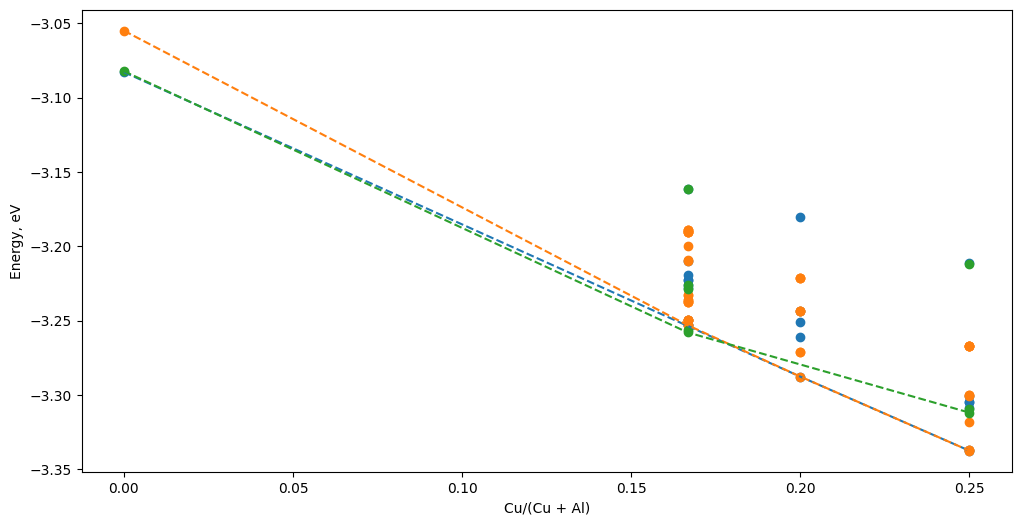

In [9]:
plot(trajfiles, geomfiles,  replace_element)


In [10]:
cleanfiles = True 

if cleanfiles:
    files = glob.glob(os.path.join(outputdir, '*.traj'))
    files += glob.glob(os.path.join(outputdir, '*.log'))
    for _ in files:
        os.remove(_)
    os.rmdir(outputdir)